In [1]:
from pathlib import Path
from glob import glob

In [2]:
data_adr = Path(r"U:\test_data")
plate_id = r"20250122_Plate017"
video_id = r"034"
frame_id1 = r"Img/Img_00000.tif"
frame_id2 = r"Img/Img_00001.tif"
# total_path = Path(r"U:\test_data\015\Img")
total_path = data_adr / plate_id / video_id / "Img"


print(total_path)

U:\test_data\20250122_Plate017\034\Img


In [ ]:
import os
import matplotlib
import numpy as np
import imageio.v3 as iio
import cv2
import matplotlib.pyplot as plt
from tqdm import tqdm
import colorcet as cc


def tif_folder_to_mp4(folder_path, output_file, fps=10, cmap=None):
    """
    Converts a folder of single-channel .tif images to an MP4 video.

    Parameters:
        folder_path (str): Path to the folder containing the .tif images.
        output_file (str): Path to save the output MP4 file.
        fps (int): Frames per second for the video.
        cmap (str): Optional Matplotlib colormap name to apply.
    """
    # Get sorted list of .tif files
    tif_files = sorted(
        [f for f in os.listdir(folder_path) if f.lower().endswith(".tif")],
    )

    if not tif_files:
        raise ValueError("No .tif files found in the specified folder.")

    frames = []

    for tif_file in tqdm(tif_files, desc="Reading files"):
        # Read the .tif image
        img_path = os.path.join(folder_path, tif_file)
        image = iio.imread(img_path)

        if cmap:
            # Apply colormap if specified
            norm_image = (image - np.min(image)) / (
                np.max(image) - np.min(image)
            )  # Normalize to [0, 1]
            colormap = matplotlib.colormaps.get_cmap(cmap)
            colored_image = (colormap(norm_image)[:, :, :3] * 255).astype(
                np.uint8
            )  # Apply colormap and convert to RGB
            colored_image = cv2.cvtColor(
                colored_image, cv2.COLOR_RGB2BGR
            )  # Convert RGB to BGR for OpenCV
            frames.append(colored_image)
        else:
            # Convert single-channel image to 3-channel grayscale
            frames.append(cv2.cvtColor(image, cv2.COLOR_GRAY2BGR))

    # Get frame dimensions
    height, width, _ = frames[0].shape

    # Initialize video writer
    fourcc = cv2.VideoWriter_fourcc(*"mp4v")
    video_writer = cv2.VideoWriter(output_file, fourcc, fps, (width, height))

    # Write frames to video
    for frame in tqdm(frames, desc="Making video"):
        video_writer.write(frame)

    video_writer.release()

    print(f"Video saved to {output_file}")


# # Example usage
# tif_folder_to_mp4(
#     total_path, total_path.parent / "output_video.mp4", fps=20, cmap="cet_fire"
# )

In [ ]:
import dask.array as da
from dask import delayed


def load_tif_series_to_dask(folder_path):
    """
    Loads a series of .tif images from a folder into a Dask array.

    Parameters:
        folder_path (str): Path to the folder containing the .tif images.

    Returns:
        dask.array.Array: A Dask array representing the .tif series.
    """
    # Get sorted list of .tif files
    tif_files = sorted(
        [
            os.path.join(folder_path, f)
            for f in os.listdir(folder_path)
            if f.lower().endswith(".tif")
        ],
        # key=lambda x: int(os.path.basename(x)[3:].split('.')[0])  # Extract number from 'Img<nr>.tif'
    )

    if not tif_files:
        raise ValueError("No .tif files found in the specified folder.")

    # Use Dask to stack images lazily
    sample_image = iio.imread(tif_files[0])
    dtype = sample_image.dtype
    shape = (len(tif_files),) + sample_image.shape

    def lazy_reader(filename):
        return iio.imread(filename)

    dask_array = da.stack(
        [
            da.from_delayed(
                delayed(lazy_reader)(file), shape=sample_image.shape, dtype=dtype
            )
            for file in tif_files
        ]
    )

    return dask_array


array = load_tif_series_to_dask(total_path)

In [ ]:
from typing import Optional
from util.coord_transforms import freqSpaceCoords
from scipy import fftpack

def angular_kernel(K=5, angles: Optional[np.ndarray] = None, N=1024):
    if angles is None:
        n = 2 * K + 1
        angles = np.arange(n) * np.pi / (n)

coord_system = freqSpaceCoords(np.array([5,5]))



[[ 0.  0.  0.  0.  0.]
 [ 1.  1.  1.  1.  1.]
 [ 2.  2.  2.  2.  2.]
 [-2. -2. -2. -2. -2.]
 [-1. -1. -1. -1. -1.]]


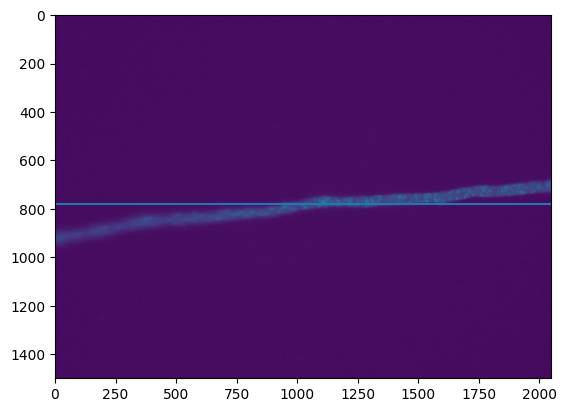

In [ ]:
line_height = 780

fig, ax = plt.subplots()
ax.imshow(array[0, :, :])
ax.axhline(line_height)

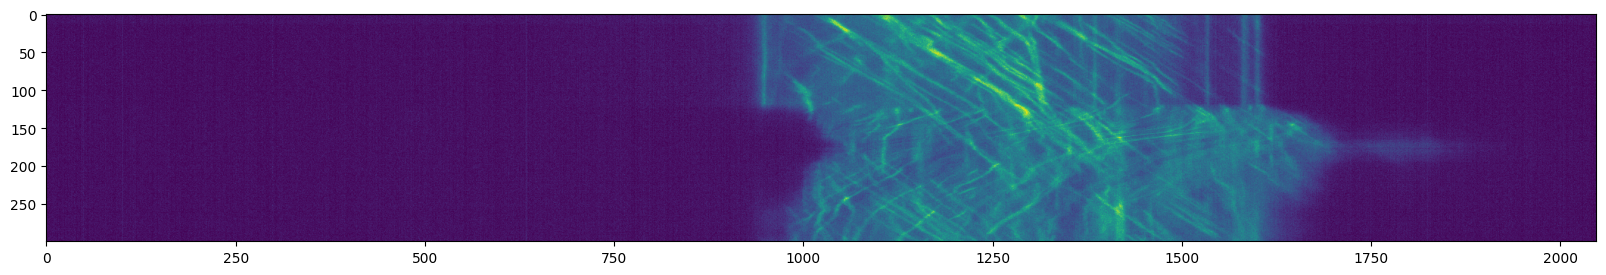

In [6]:
fix, ax = plt.subplots(figsize=(20, 8))
ax.imshow(array[:, line_height, :])